In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  
import sqlite3
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

In [2]:


# Specify the input file path (assuming it's a SQLite database file)
input_file_path = 'History'

# Connect to the SQLite database
conn = sqlite3.connect(input_file_path)

# Define the SQL query to retrieve data from the 'urls' table
sql_statement = "SELECT url, title, datetime(last_visit_time/1000000-11644473600,'unixepoch') FROM urls;"

# Execute the SQL query and store the result in a Pandas DataFrame
df = pd.read_sql_query(sql_statement, conn)

# Rename the columns in the DataFrame
df.columns = ["URL", "Title", "Time"]

# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Extract additional information from the 'Time' column and create new columns
df['Hour'] = df['Time'].dt.hour
df['Minutes'] = df['Time'].dt.minute
df['Weekday'] = df['Time'].dt.weekday
df['Month'] = df['Time'].dt.to_period('M')

# Calculate the dwell time for each title by finding the time difference between consecutive rows
df['Dwell_Time'] = df.groupby('Title')['Time'].diff().dt.total_seconds()
#print columns of the data frame
print(df.columns)



Index(['URL', 'Title', 'Time', 'Hour', 'Minutes', 'Weekday', 'Month',
       'Dwell_Time'],
      dtype='object')


In [3]:
# Set the 'Time' column as the index of the DataFrame
df.index = df['Time']

# Remove the 'Time' column from the DataFrame (since it's now the index)
del df['Time']


In [4]:
headers = requests.utils.default_headers()
headers.update(
    {
        'User-Agent': 'Custom User Agent 1.0',
        'From': 'sovansahoo23@iitk.ac.in'  # Stick in your IITK email id
    }
)


In [5]:
# Save the DataFrame to a CSV file named 'chrome_historyR.csv'
df.to_csv('chrome_historyR.csv')


In [6]:
# Read the CSV file 'chrome_historyR.csv' into a new DataFrame 'df'
df = pd.read_csv('chrome_historyR.csv')

# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Get unique values in the 'Title' column and store them in the 'docs' variable
docs = df.Title.unique()


In [7]:
df.head(50)

,Time,URL,Title,Hour,Minutes,Weekday,Month,Dwell_Time
0,2023-11-01 15:13:04,https://accounts.google.com/signin/chrome/sync...,Sign in - Google Accounts,15,13,2,2023-11,NaN
1,2023-11-01 15:13:04,https://accounts.google.com/v3/signin/identifi...,Sign in - Google Accounts,15,13,2,2023-11,0.0
2,2023-11-01 15:13:23,https://accounts.google.com/v3/signin/challeng...,Sign in - Google Accounts,15,13,2,2023-11,19.0
3,2023-11-01 15:13:55,https://accounts.google.com/v3/signin/challeng...,Sign in - Google Accounts,15,13,2,2023-11,32.0
4,2023-11-01 15:14:11,https://www.wolframalpha.com/input/?i=root+loc...,root locus plot for transfer function (1)/(s^4...,15,14,2,2023-11,NaN
5,2023-11-01 15:14:11,https://www.wolframalpha.com/input/?i=Nyquist+...,Nyquist plot of the transfer function (s+3)/((...,15,14,2,2023-11,NaN
6,2023-11-01 15:14:11,https://govtjobguru.in/jobs-by-post/engineerin...,Govt Jobs for Engineers 2020 - Latest Vacancies,15,14,2,2023-11,NaN
7,2023-11-01 15:14:11,http://www.sarkaritel.com/ministries/secretary...,": Ministries, Secretaries to Government of Ind...",15,14,2,2023-11,NaN
8,2024-01-18 15:12:24,https://www.youtube.com/,(516) YouTube,15,12,3,2024-01,NaN
9,2023-11-01 15:14:11,https://www.kopykitab.com/blog/expert-month-wi...,Expert Month Wise Study Plan to crack ESE (IES...,15,14,2,2023-11,NaN


In [8]:


# Instantiate a tokenizer object using a regular expression for word tokenization
tokenizer = RegexpTokenizer(r'\w+')
 
# The 'RegexpTokenizer' is imported from the 'nltk.tokenize' module.
# It is used to create a tokenizer object that tokenizes words based on the provided regular expression (r'\w+' in this case).
# This regular expression matches one or more word characters (alphanumeric characters and underscores).

# Import get_stop_words from the stop_words module for obtaining English stop words
from stop_words import get_stop_words

# Create a list of English stop words using the get_stop_words function
en_stop = get_stop_words('en')

# The 'get_stop_words' function from the 'stop_words' module is used to obtain a list of English stop words.
# Stop words are common words (e.g., "the," "and," "is") that are often excluded from text analysis tasks.

# Import the PorterStemmer from nltk.stem.porter
from nltk.stem.porter import PorterStemmer

# Instantiate a PorterStemmer object
p_stemmer = PorterStemmer()

# The 'PorterStemmer' is imported from the 'nltk.stem.porter' module.
# It is used to create a stemming object ('p_stemmer') based on the 


In [9]:
# Convert the 'docs' variable (array of unique titles) to a Python list
doc_set = docs.tolist()

In [11]:
texts = []

# loop through document list
for i in doc_set:
    try:
        i.encode()
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
    
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
        # add tokens to list
        texts.append(stemmed_tokens)
    except AttributeError:
        texts.append([])
        pass
    except UnicodeDecodeError:
        texts.append([])
        pass



In [12]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]


In [13]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [14]:
# Import necessary libraries from pyLDAvis for visualizing LDA topics
import pyLDAvis
import pyLDAvis.gensim

# Enable the notebook mode for Jupyter Notebooks
pyLDAvis.enable_notebook()

# Assuming 'ldamodel' is your Gensim LDA model, 'corpus' is the document-term matrix, and 'dictionary' is the Gensim dictionary

# Generate LDA visualization using pyLDAvis
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds="mmds", R=30)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=90387) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <numbe

In [16]:
ldamodel.print_topics(3)

[(0,
  '0.029*"youtub" + 0.020*"india" + 0.019*"x" + 0.015*"s" + 0.010*"क" + 0.006*"news" + 0.006*"t" + 0.006*"indian" + 0.006*"र" + 0.005*"न"'),
 (1,
  '0.058*"youtub" + 0.011*"coursera" + 0.009*"1" + 0.009*"python" + 0.008*"data" + 0.006*"learn" + 0.006*"2" + 0.006*"l" + 0.005*"vs" + 0.005*"food"'),
 (2,
  '0.111*"search" + 0.108*"googl" + 0.020*"iit" + 0.015*"kanpur" + 0.009*"instagram" + 0.006*"varanasi" + 0.005*"program" + 0.005*"photo" + 0.004*"linkedin" + 0.004*"iitk"')]

In [17]:
ldamodel.get_topic_terms(0,10)

[(32, 0.029279174),
 (27, 0.019768221),
 (302, 0.018530533),
 (15, 0.015446123),
 (1997, 0.0095841335),
 (139, 0.0060265623),
 (309, 0.0059947586),
 (136, 0.0058281925),
 (59, 0.0057363966),
 (1349, 0.005256064)]

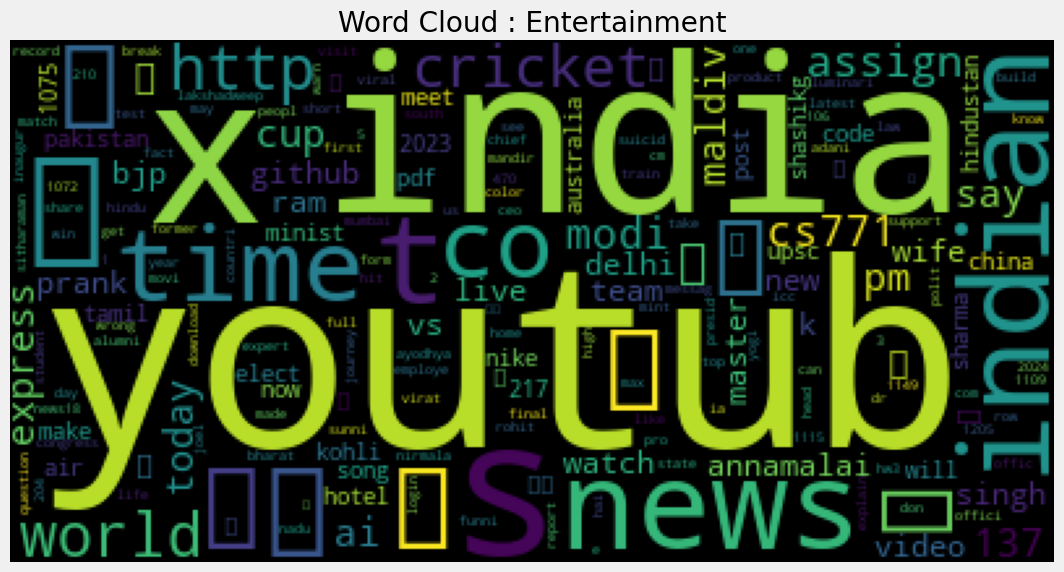

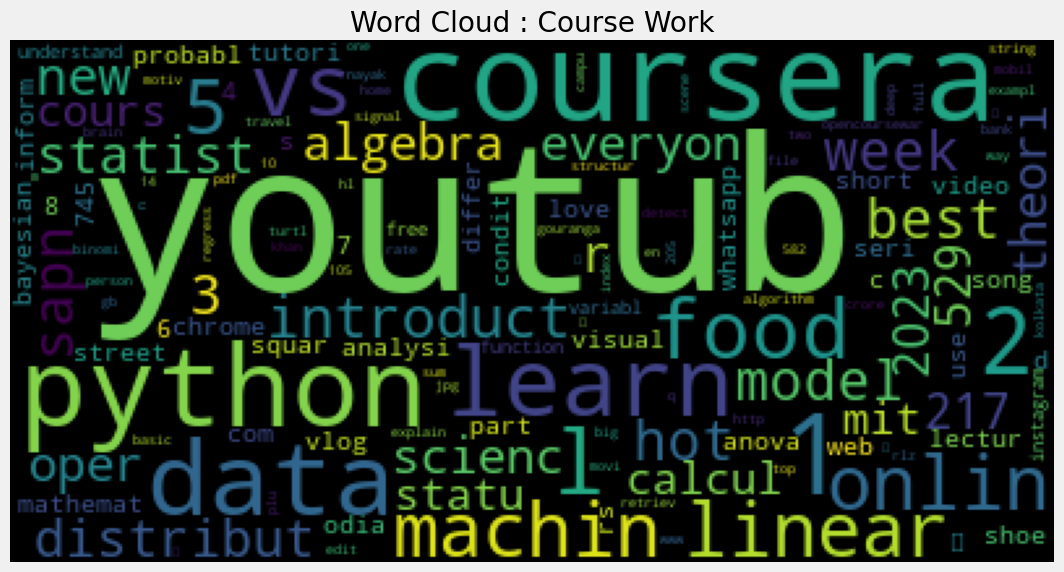

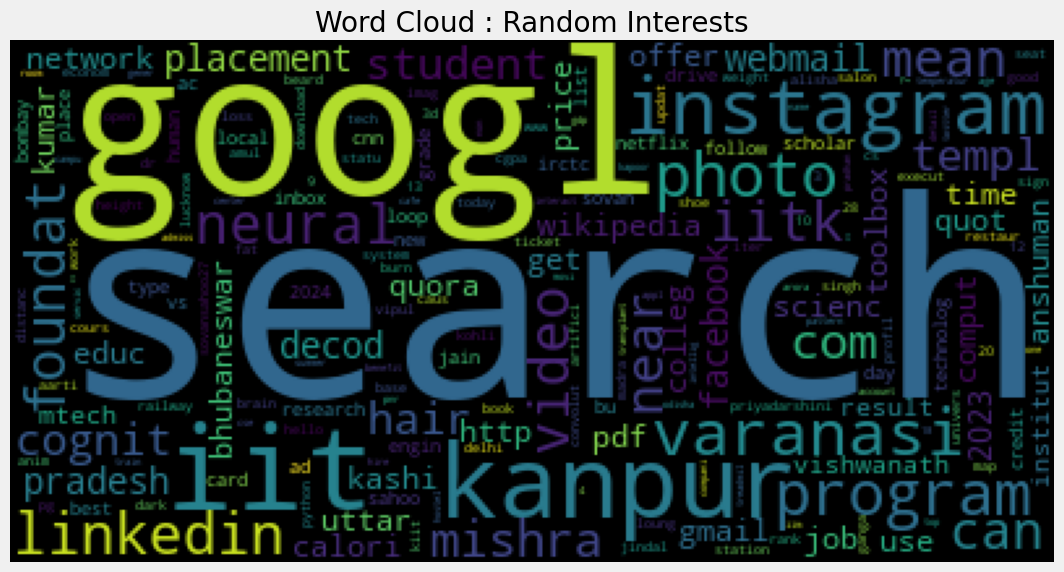

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have custom names for topics 0, 1, and 2
topic_names = {0: 'Entertainment', 1: 'Course Work', 2: 'Random Interests'}

for t in range(ldamodel.num_topics):
    plt.figure(figsize=(12, 8))
    
    # Get the topic words and probabilities
    topic_words = ldamodel.show_topic(t, 200)
    
    # Convert the list of tuples to a dictionary
    word_freq = {word: prob for word, prob in topic_words}
    
    # Create and display the word cloud
    wordcloud = WordCloud().fit_words(word_freq)
    
    plt.imshow(wordcloud)
    plt.axis("off")
    
    # Use the topic_names dictionary to get the custom name for the topic
    topic_name = topic_names.get(t, f'Unknown Topic {t}')
    
    plt.title(f"Word Cloud : {topic_name}")
    
    # Uncomment the following line if you want to save the word cloud as an image
    plt.savefig(f'wordcloud_topic_{t}.png', bbox_inches='tight')
    
    plt.show()


In [28]:
# Create an empty list 'topic' with the same length as the DataFrame 'df'
topic = [0] * len(df)

# Iterate through each row in the DataFrame 'df'
for idx in range(len(df)):
    # Find the index of the current document title in the 'doc_set'
    test_idx = doc_set.index(df.Title[idx])

    # Get the topic probabilities for the current document using the LDA model
    probs = ldamodel[dictionary.doc2bow(texts[test_idx])]

    # Flatten the list of probabilities
    prs = [item for sublist in probs for item in sublist]

    # Extract the probabilities of each topic
    topicProbs = [i[1] for i in probs]

    # Find the index of the topic with the highest probability
    topic[idx] = np.argmax(np.asarray(topicProbs))


In [29]:
df['Topic'] = topic

In [30]:
df.head()

,Time,URL,Title,Hour,Minutes,Weekday,Month,Dwell_Time,Topic
0,2023-11-01 15:13:04,https://accounts.google.com/signin/chrome/sync...,Sign in - Google Accounts,15,13,2,11,NaN,2
1,2023-11-01 15:13:04,https://accounts.google.com/v3/signin/identifi...,Sign in - Google Accounts,15,13,2,11,0.0,2
2,2023-11-01 15:13:23,https://accounts.google.com/v3/signin/challeng...,Sign in - Google Accounts,15,13,2,11,19.0,2
3,2023-11-01 15:13:55,https://accounts.google.com/v3/signin/challeng...,Sign in - Google Accounts,15,13,2,11,32.0,2
4,2023-11-01 15:14:11,https://www.wolframalpha.com/input/?i=root+loc...,root locus plot for transfer function (1)/(s^4...,15,14,2,11,NaN,0


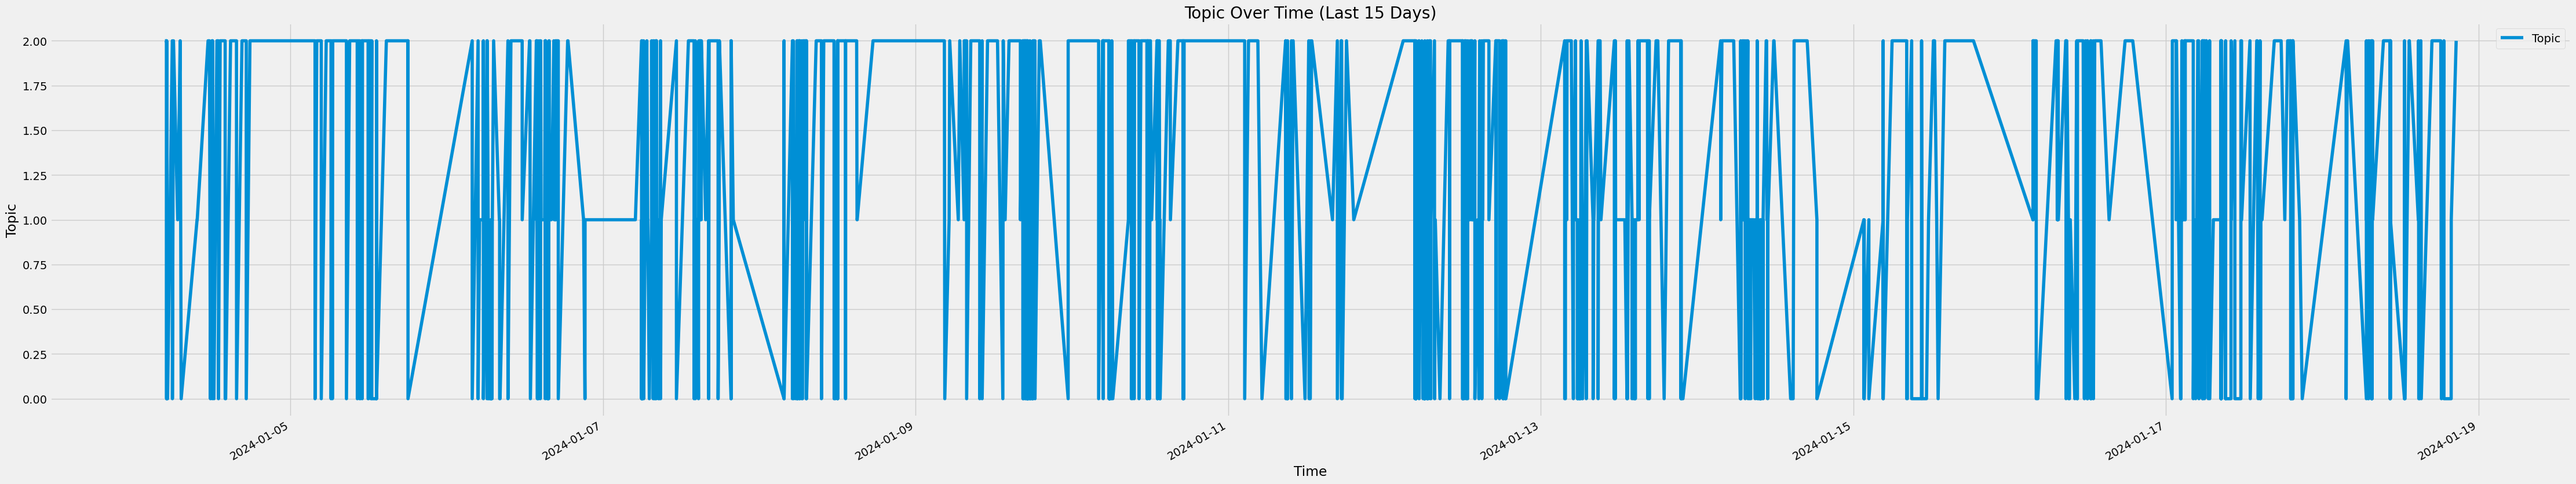

In [31]:

# Find the maximum date in the dataset
max_date = df['Time'].max()

# Filter data for the last 30 days from the maximum date
last_30_days_data = df[(df['Time'] >= max_date - pd.DateOffset(days=15)) & (df['Time'] <= max_date)]

# Sort the DataFrame based on 'Time'
sorted_data = last_30_days_data.sort_values('Time')

# Plotting
plt.style.use('fivethirtyeight')

# Plot the 'Topic' column over time
sorted_data.plot(x='Time', y='Topic', figsize=(50, 10))

# Add labels and title to the plot
plt.xlabel('Time')
plt.ylabel('Topic')
plt.title('Topic Over Time (Last 15 Days)')

# Save the plot as a PNG file in the working directory
plt.savefig('topic_over_time_plot.png', bbox_inches='tight')

# Display the plot
plt.show()






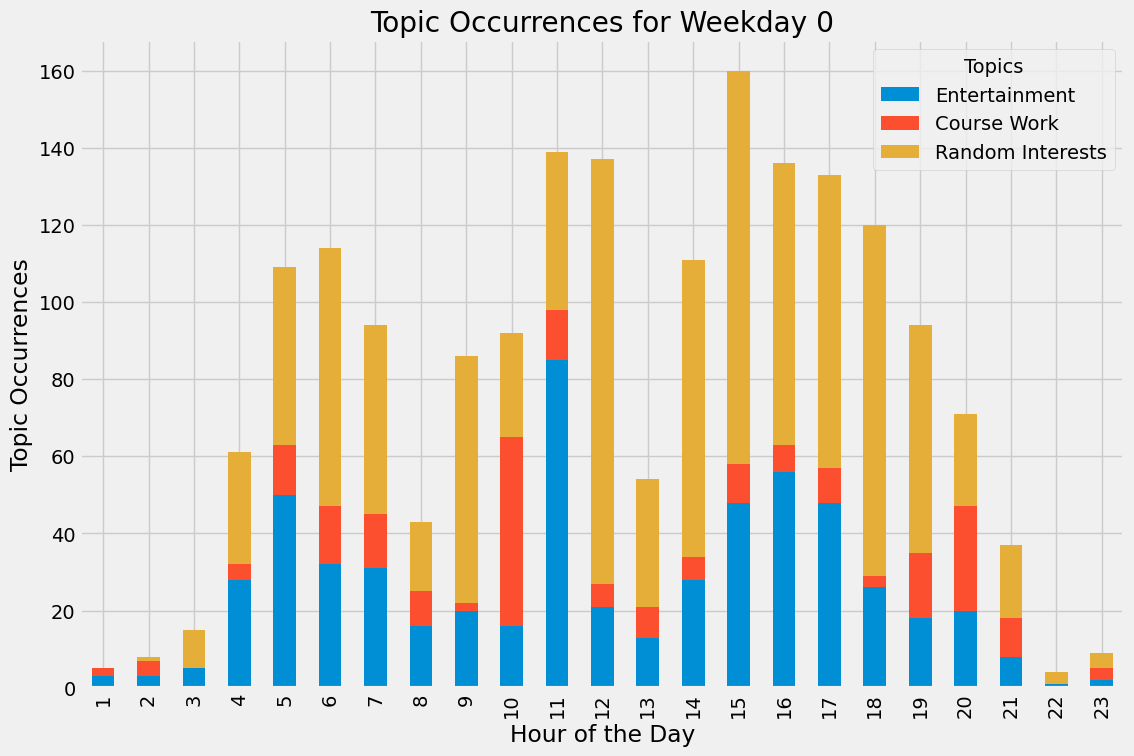

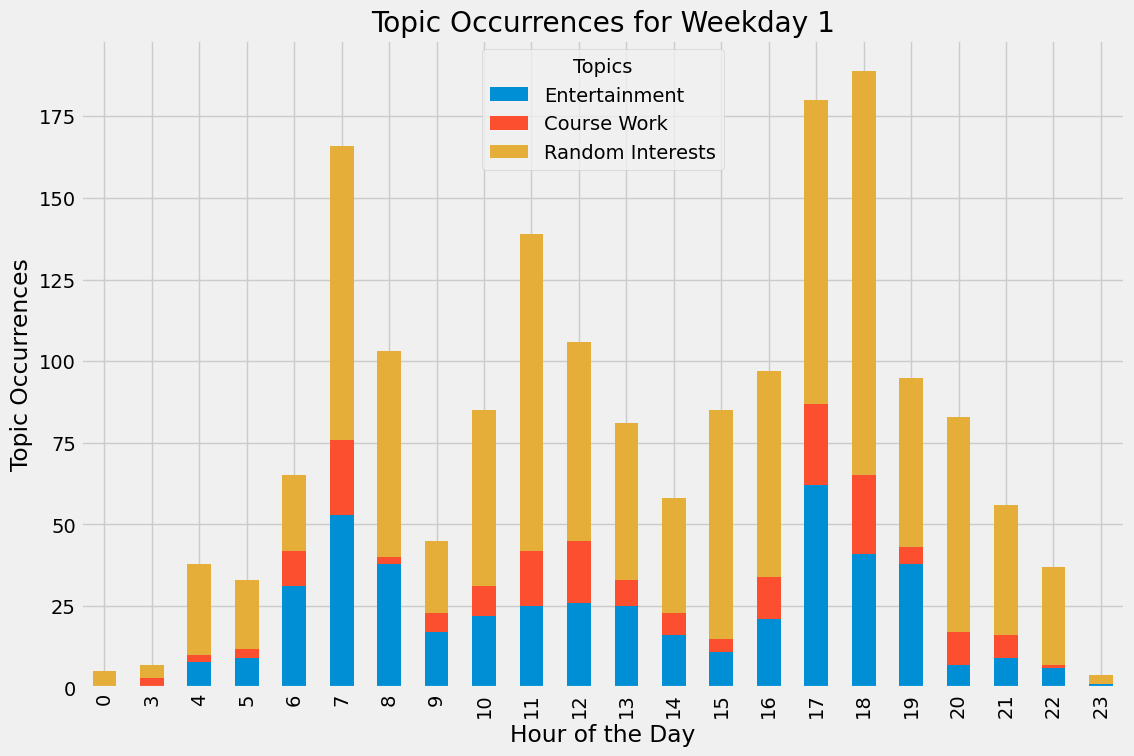

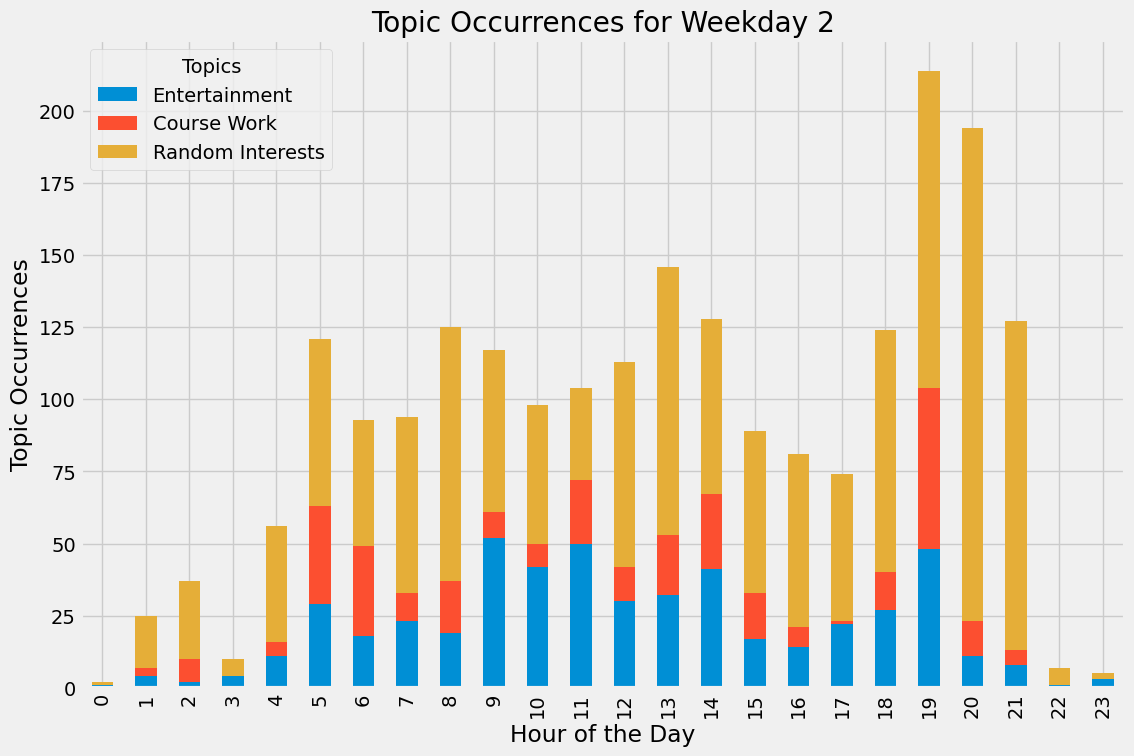

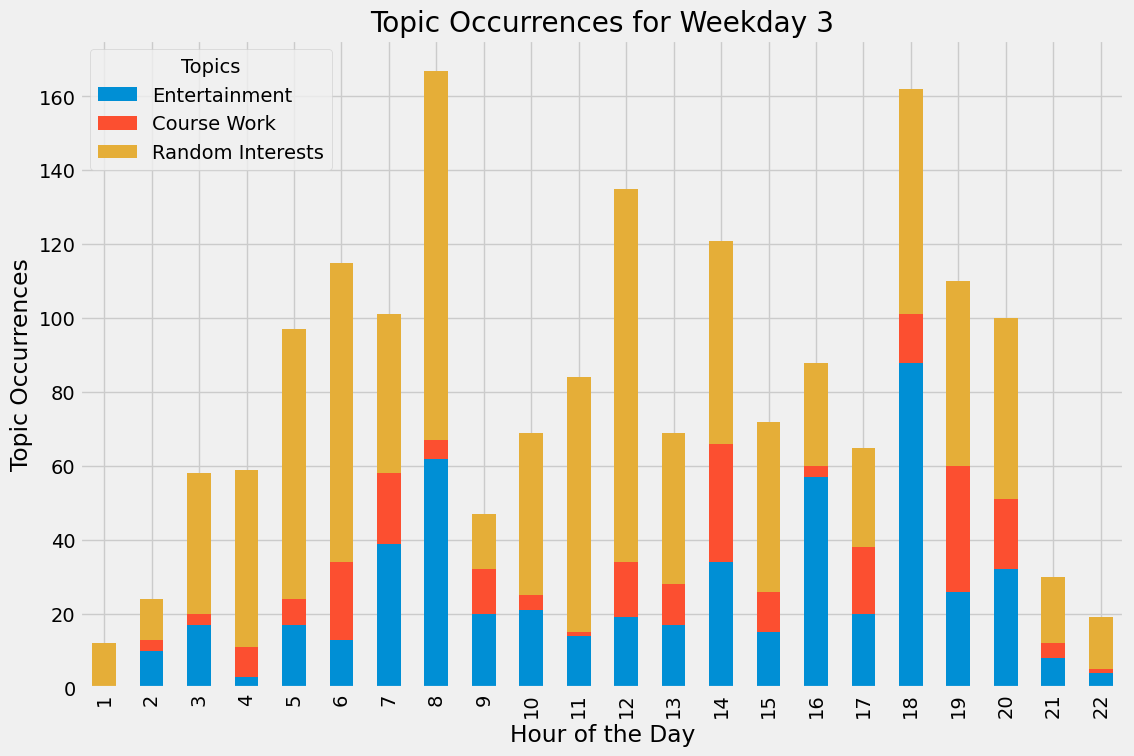

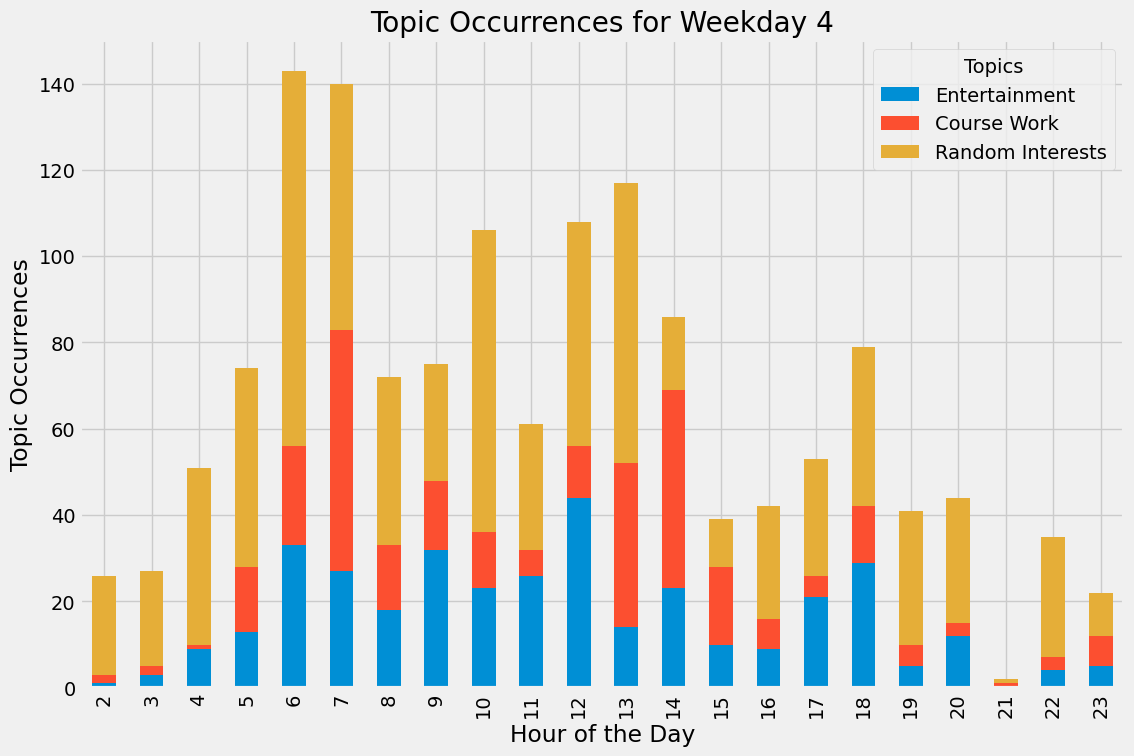

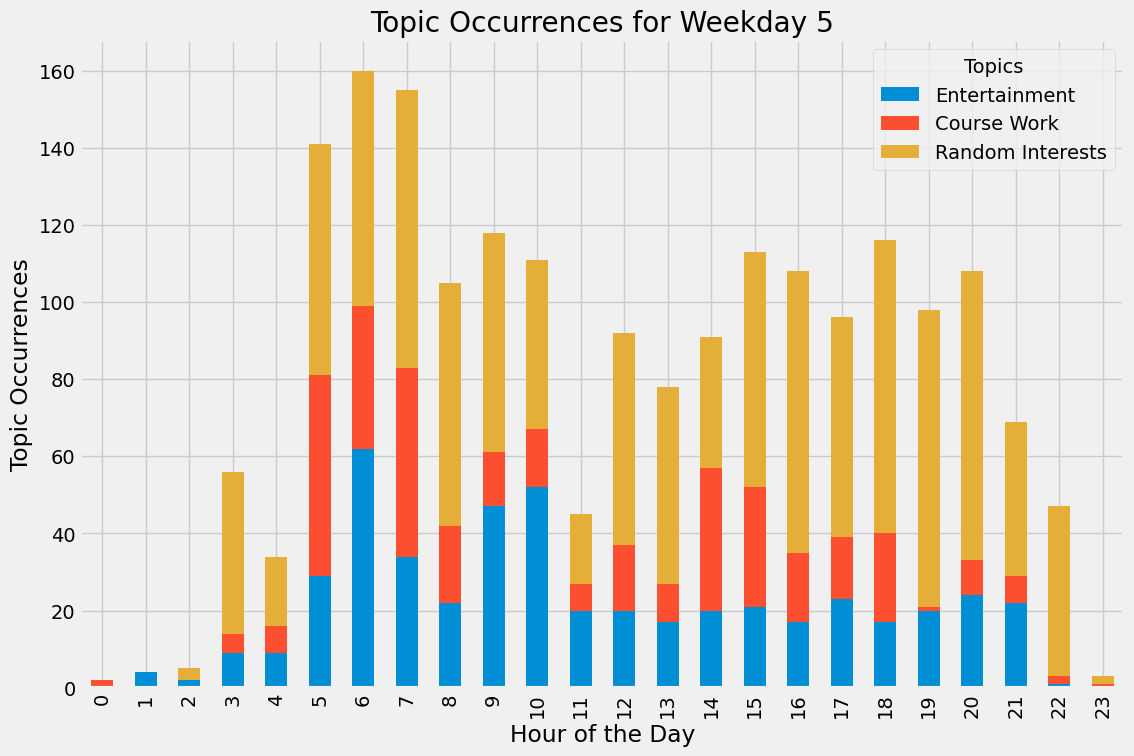

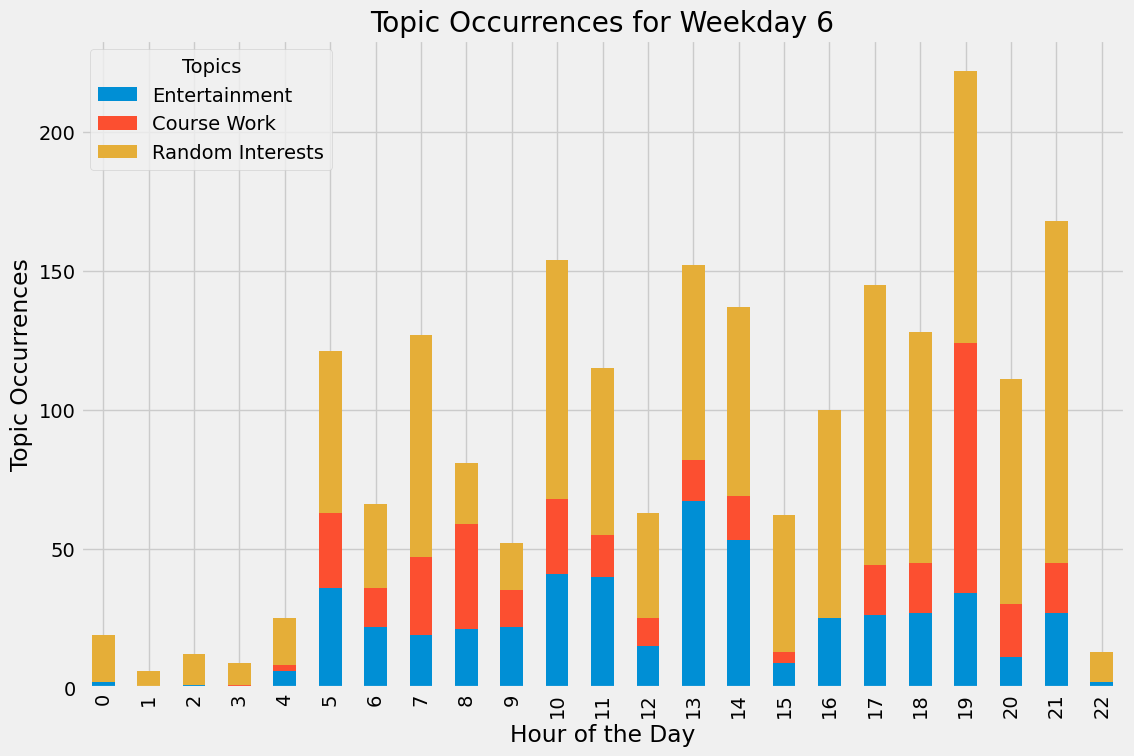

In [35]:


# Group data by weekday, hour, and topic
weekday_hourly_topic_counts = df.groupby(['Weekday', 'Hour', 'Topic']).size().unstack()

# Plotting for each weekday
for i in range(7):
    # Select data for the current weekday
    weekday_data = weekday_hourly_topic_counts.loc[i].fillna(0)
    
    # Create a new figure and axis for each iteration
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plotting
    weekday_data.plot(kind='bar', stacked=True, ax=ax)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Topic Occurrences')
    plt.title(f'Topic Occurrences for Weekday {i}')
    
    # Customize Legends
    legend_labels = {0: 'Entertainment', 1: 'Course Work', 2: 'Random Interests'}  # Update labels as per your topics

    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Create a legend with custom labels and handles
    ax.legend(handles, [legend_labels[int(label)] for label in labels], title='Topics')

    # Save the plot as a PNG file in the working directory
    plt.savefig(f'topic_occurrences_weekday_{i}.png', bbox_inches='tight')

    # Display the plot
    plt.show()


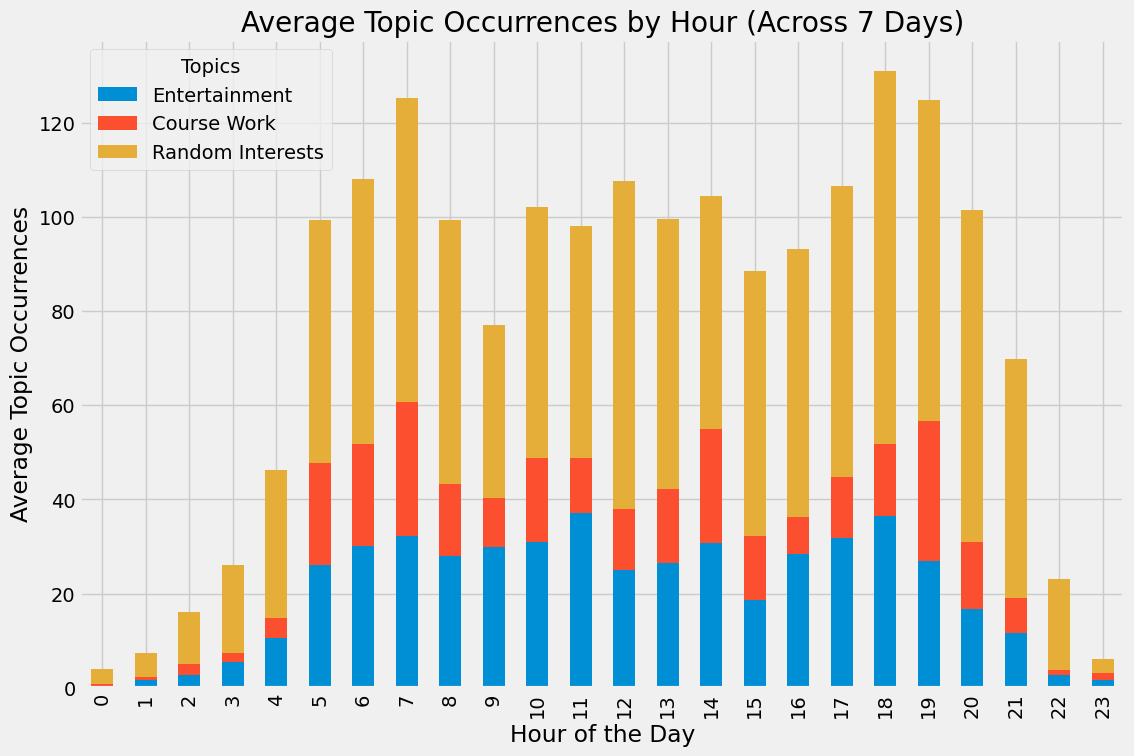

In [36]:


# Group data by hour and topic
hourly_topic_counts = df.groupby(['Hour', 'Topic']).size().unstack()

# Calculate the average occurrences by dividing by the number of days
hourly_topic_counts_avg = hourly_topic_counts.div(7).fillna(0)

# Plotting
ax = hourly_topic_counts_avg.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title to the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Average Topic Occurrences')
plt.title('Average Topic Occurrences by Hour (Across 7 Days)')

# Customize Legends
legend_labels = {0: 'Entertainment', 1: 'Course Work', 2: 'Random Interests'}  # Update labels as per your topics

# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create a legend with custom labels and handles
ax.legend(handles, [legend_labels[int(label)] for label in labels], title='Topics')

# Save the plot as a PNG file in the working directory
plt.savefig('average_topic_occurrences_by_hour.png', bbox_inches='tight')

# Display the plot
plt.show()


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Check the data type of the 'Month' column
if df['Month'].dtype == 'object':
    # Convert the 'Month' column to numeric format if it's an object type
    df['Month'] = pd.to_numeric(df['Month'].str.split('-').str[1])

# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Features and target
features = ['Hour', 'Minutes', 'Weekday', 'Month']
X_train = train_data[features]
y_train = train_data['Topic']
X_test = test_data[features]
y_test_true = test_data['Topic']

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate the classifier using cross-validation
cv_accuracy = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
print(f"Cross-Validation Accuracy: {cv_accuracy}")

# Make predictions on the test set
y_test_pred = clf.predict(X_test_scaled)


accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Set Accuracy: {accuracy}")

# User Input and Prediction for Current Time
current_time = datetime.now()
user_weekday = current_time.weekday()
user_hour = current_time.hour
user_minutes = current_time.minute
user_month = current_time.month

topic_names = {0: 'Entertainment', 1: 'Course Work', 2: 'Random Interests'}

user_prediction = clf.predict([[user_hour, user_minutes, user_weekday, user_month]])
predicted_topic_number = user_prediction[0]


predicted_topic_name = topic_names.get(predicted_topic_number, f'Unknown Topic {predicted_topic_number}')

print(f"Predicted Topic for current time (weekday {user_weekday}, month {user_month}, {user_hour}:{user_minutes}): {predicted_topic_name}")


Cross-Validation Accuracy: 0.7170334928229666
Test Set Accuracy: 0.7045541523153463
Predicted Topic for current time (weekday 2, month 1, 18:52): Random Interests
